![Peek My Home Price Home Page](https://raw.githubusercontent.com/adamcseresznye/peek_my_home_price/refs/heads/main/screenshot.png){fig-align="center"}


In Part 2, we looked into some crucial sample pre-processing steps before modeling, establishing the required pipeline for data processing, evaluating various algorithms, and ultimately identifying an appropriate baseline model, that is CatBoost. As we proceed to Part 3, our focus will be on assessing the significance of features in the initial scraped dataset. We'll achieve this by employing the `feature_importances_` method of CatBoostRegressor and analyzing SHAP values. Additionally, we'll systematically eliminate features showing lower importance or predictive capability. Excited to explore all these!

::: {.callout-note}
You can explore the project's app on its [website](https://peek-my-home-price.fly.dev/). For more details, visit the [GitHub repository](https://github.com/adamcseresznye/peek_my_home_price).

Check out the series for a deeper dive:
- [Part 1: Characterizing the Data](https://adamcseresznye.github.io/projects/peek_my_home_price/part-1_characterizing_the_data.html)
- [Part 2: Building a Baseline Model](https://adamcseresznye.github.io/projects/peek_my_home_price/part-2_building_a_baseline_model.html)
- [Part 3: Feature Selection](https://adamcseresznye.github.io/projects/peek_my_home_price/part-3_feature_selection.html)
- [Part 4: Feature Engineering](https://adamcseresznye.github.io/projects/peek_my_home_price/part-4_feature_engineering.html)
- [Part 5: Fine-Tuning](https://adamcseresznye.github.io/projects/peek_my_home_price/part-5_fine_tuning.html)
:::

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd()))

In [2]:
from pathlib import Path

import catboost
import numpy as np
import pandas as pd
import shap
from IPython.display import clear_output
from lets_plot import *
from lets_plot.mapping import as_discrete
from sklearn import metrics, model_selection
from tqdm import tqdm

from helper import utils

LetsPlot.setup_html()

# Prepare dataframe before modelling
## Read in dataframe


In [3]:
df = pd.read_parquet(
    Path.cwd().joinpath("data").joinpath("2023-10-01_Processed_dataset_for_NB_use.gzip")
)

## Train-test split

Our initial step involves a train-test split. This process divides the data into two distinct sets: a training set and a testing set. The training set is employed for model training, while the testing set is exclusively reserved for model evaluation. This methodology allows models to be trained on the training set and then assessed for accuracy using the unseen testing set. Ultimately, this approach enables an unbiased evaluation of our model's performance, utilizing the test set that remained untouched during the model training phase.

In [4]:
train, test = model_selection.train_test_split(
    df, test_size=0.2, random_state=utils.Configuration.seed
)

print(f"Shape of train: {train.shape}")
print(f"Shape of test: {test.shape}")

Shape of train: (2928, 50)
Shape of test: (732, 50)


## Preprocess dataframe for modelling

Next, we'll apply a crucial step in our data preprocessing pipeline: transforming our target variable using a logarithmic function. Additionally, we'll tackle missing values in our categorical features by replacing them with a designated label, "missing value." This is needed, as CatBoost can handle missing values in numerical columns, but categorical missing values require manual attention to ensure accurate modeling.


In [5]:
processed_train = train.reset_index(drop=True).assign(
    price=lambda df: np.log10(df.price)
)  # Log transformation of 'price' column

# This step is needed since catboost cannot handle missing values when feature is categorical
for col in processed_train.columns:
    if processed_train[col].dtype.name in ("bool", "object", "category"):
        processed_train[col] = processed_train[col].fillna("missing value")

processed_train.shape

(2928, 50)

# Inspect feature importance

We will evaluate feature importance using two methods: the `feature_importances_` attribute in CatBoost and SHAP values from the SHAP library. To begin examining feature importances, we'll initiate model training. This involves further partitioning the training set, reserving a portion for CatBoost training (validation dataset). This allows us to stop the training process when overfitting emerges. Preventing overfitting is crucial, as it ensures we don't work with an overly biased model. Additionally, if overfitting occurs, stopping training earlier helps conserve time and resources.

In [6]:
features = processed_train.columns[~processed_train.columns.str.contains("price")]

numerical_features = processed_train.select_dtypes("number").columns.to_list()
categorical_features = processed_train.select_dtypes("object").columns.to_list()

train_FS, validation_FS = model_selection.train_test_split(
    processed_train, test_size=0.2, random_state=utils.Configuration.seed
)

# Get target variables
tr_y = train_FS[utils.Configuration.target_col]
val_y = validation_FS[utils.Configuration.target_col]

# Get feature matrices
tr_X = train_FS.loc[:, features]
val_X = validation_FS.loc[:, features]


print(f"Train dataset shape: {tr_X.shape} {tr_y.shape}")
print(f"Validation dataset shape: {val_X.shape} {val_y.shape}")

Train dataset shape: (2342, 49) (2342,)
Validation dataset shape: (586, 49) (586,)


In [7]:
train_dataset = catboost.Pool(tr_X, tr_y, cat_features=categorical_features)
validation_dataset = catboost.Pool(val_X, val_y, cat_features=categorical_features)

As you can see below, the training loss steadily decreases, but the validation loss reaches a plateau. Thanks to the validation dataset, we can stop the training well before the initially set 2000 iterations. This early stopping is crucial for preventing overfitting and ensures a more balanced and effective model.

In [8]:
model = catboost.CatBoostRegressor(
    iterations=2000,
    random_seed=utils.Configuration.seed,
    loss_function="RMSE",
)

model.fit(
    train_dataset,
    eval_set=[validation_dataset],
    early_stopping_rounds=20,
    use_best_model=True,
    verbose=2000,
    plot=False,
)

Learning rate set to 0.038132
0:	learn: 0.3187437	test: 0.3148628	best: 0.3148628 (0)	total: 315ms	remaining: 10m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1087393065
bestIteration = 850

Shrink model to first 851 iterations.


According to our trained CatBoost model, the most significant feature in our dataset is the living_area, followed by cadastral_income and latitude. To validate and compare these findings, we'll examine the SHAP values to understand how they align or differ from the feature importances provided by the model.

In [9]:
# | fig-cap: "Assessing Feature Importance"
# | label: fig-fig1

(
    pd.concat(
        [pd.Series(model.feature_names_), pd.Series(model.feature_importances_)], axis=1
    )
    .sort_values(by=1, ascending=False)
    .rename(columns={0: "name", 1: "importance"})
    .reset_index(drop=True)
    .pipe(
        lambda df: ggplot(df, aes("name", "importance"))
        + geom_bar(stat="identity")
        + labs(
            title="Assessing Feature Importance",
            subtitle=""" based on the feature_importances_ attribute
            """,
            x="",
            y="Feature Importance",
        )
        + theme(
            plot_subtitle=element_text(
                size=12, face="italic"
            ),  # Customize subtitle appearance
            plot_title=element_text(size=15, face="bold"),  # Customize title appearance
        )
        + ggsize(800, 600)
    )
)

# SHAP

SHAP (SHapley Additive exPlanations) values offer a method to understand the predictions made by any machine learning model. These values leverage a game-theoretic approach to quantify the contribution of each "player" (feature) to the final prediction. In the realm of machine learning, SHAP values assign an importance value to each feature, delineating its contribution to the model's output.

SHAP values provide detailed insights into how each feature influences individual predictions, their relative significance in comparison to one another, and the model's reliance on interactions between features. This comprehensive perspective enables a deeper understanding of the factors that drive the model's decision-making process.

In this phase, our primary focus will involve computing SHAP values and then creating visualizations, such as bar plots and beeswarm plots, to illustrate feature importance and interactionss.

In [10]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(
    catboost.Pool(tr_X, tr_y, cat_features=categorical_features)
)

The summary plot at @fig-fig2 provides a clear depiction of feature importance within the model. The outcomes reveal that "Living area," "Surface of the plot," and "Cadastral income" emerge as important factors in influencing the model's predictions. These features prominently contribute to determining the model's results.

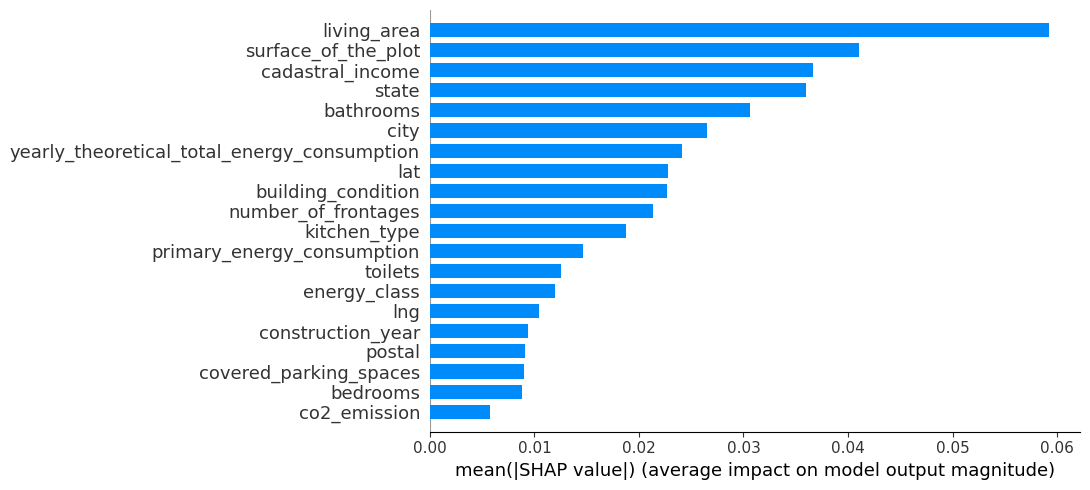

In [11]:
# | fig-cap: "Assessing Feature Importance using bar plot"
# | label: fig-fig2

shap.summary_plot(shap_values, tr_X, plot_type="bar", plot_size=[11, 5])

The beeswarm plot (@fig-fig3) can be best understood through the following breakdown:

- The Y-axis arranges the feature names based on their importance, with the most influential features placed at the top.
- The X-axis displays the SHAP value, representing the impact of each feature on the model's output. Features on the right side of the plot exhibit a stronger impact, while those on the left possess a weaker influence.

Moreover:
- Each point's color on the plot signifies the respective feature's value for that specific data point. Red indicates high values, while blue represents low values.
- Every individual point on the plot corresponds to a particular row from the original dataset. Collectively, these points illustrate how different data points and their associated feature values contribute to the model's predictions, especially concerning feature importance.

Upon examining the "living area" feature, you'll notice it predominantly displays a high positive SHAP value. This suggests that a larger living area tends to have a positive effect on the output, which in this context is the price. Conversely, higher values of "primary energy consumption" are associated with a negative impact on the price, reflected by their negative SHAP values.

Consideration of the spread of SHAP values and their relation to predictive power is important. A wider spread or a denser distribution of data points implies greater variability or a more significant influence on the model's predictions. This insight allows us to evaluate the significance of features regarding their contribution to the model's overall output.

This context clarifies why "living area" holds greater importance compared to "CO2 emission." The broader impact and higher variability of the "living area" feature in influencing the model's predictions make it a more crucial determinant of the output, thus carrying more weight in the model's decision-making process.rtance.

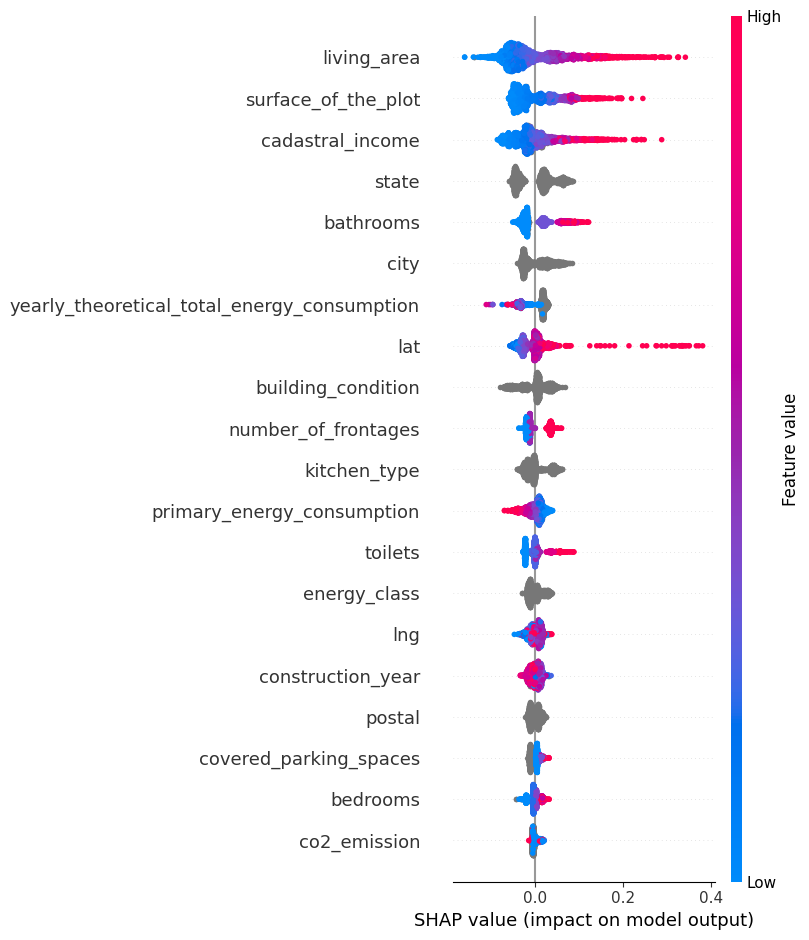

In [12]:
# | fig-cap: "Assessing Feature Importance using beeswarm plot"
# | label: fig-fig3

shap.summary_plot(shap_values, tr_X)

Let's examine the ranking or order of feature importances derived from both Gini impurity and SHAP values to understand how they compare and whether they yield similar or differing insights. As you can see from the table below, they are fairly similar.

In [13]:
catboost_feature_importance = (
    pd.concat(
        [pd.Series(model.feature_names_), pd.Series(model.feature_importances_)], axis=1
    )
    .sort_values(by=1, ascending=False)
    .rename(columns={0: "catboost_name", 1: "importance"})
    .reset_index(drop=True)
)

In [14]:
shap_feature_importance = (
    pd.DataFrame(shap_values, columns=tr_X.columns)
    .abs()
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "shap_name", 0: "shap"})
)

In [15]:
pd.concat(
    [
        catboost_feature_importance.drop(columns="importance"),
        shap_feature_importance.drop(columns="shap"),
    ],
    axis=1,
)

,catboost_name,shap_name
0,living_area,living_area
1,cadastral_income,surface_of_the_plot
2,lat,cadastral_income
3,state,state
4,bathrooms,bathrooms
5,surface_of_the_plot,city
6,city,yearly_theoretical_total_energy_consumption
7,building_condition,lat
8,kitchen_type,building_condition
9,yearly_theoretical_total_energy_consumption,number_of_frontages


# Recursive feature elimination based on SHAP values

Next, we'll work on the initial feature elimination process based on SHAP values using CatBoost's `select_features` method. Although a rich set of features can be advantageous, the quest for model interpretability prompts us to consider the need for a streamlined feature set.

Our objective here is to remove features that have minimal impact on the final predictive output, retaining only the most influential ones. This action streamlines our model, enhancing its interpretability and making it easier to understand the factors driving its predictions.

In [16]:
regressor = catboost.CatBoostRegressor(
    iterations=1000,
    cat_features=categorical_features,
    random_seed=utils.Configuration.seed,
    loss_function="RMSE",
)

rfe_dict = regressor.select_features(
    algorithm="RecursiveByShapValues",
    shap_calc_type="Exact",
    X=tr_X,
    y=tr_y,
    eval_set=(val_X, val_y),
    features_for_select="0-48",
    num_features_to_select=1,
    steps=10,
    verbose=2000,
    train_final_model=False,
    plot=False,
)

Learning rate set to 0.0582
Step #1 out of 10
0:	learn: 0.3152318	test: 0.3115119	best: 0.3115119 (0)	total: 65.4ms	remaining: 1m 5s
999:	learn: 0.0474957	test: 0.1066737	best: 0.1065423 (961)	total: 31.1s	remaining: 0us

bestTest = 0.1065422651
bestIteration = 961

Shrink model to first 962 iterations.
Feature #38 eliminated
Feature #28 eliminated
Feature #20 eliminated
Feature #22 eliminated
Feature #19 eliminated
Feature #14 eliminated
Feature #11 eliminated
Feature #0 eliminated
Feature #31 eliminated
Feature #15 eliminated
Feature #30 eliminated
Feature #41 eliminated
Feature #33 eliminated
Feature #17 eliminated
Feature #45 eliminated
Feature #18 eliminated
Step #2 out of 10
0:	learn: 0.3155660	test: 0.3112354	best: 0.3112354 (0)	total: 22.5ms	remaining: 22.5s
999:	learn: 0.0505860	test: 0.1056381	best: 0.1056078 (984)	total: 17.1s	remaining: 0us

bestTest = 0.1056077628
bestIteration = 984

Shrink model to first 985 iterations.
Feature #39 eliminated
Feature #2 eliminated
Featur

Through Recursive Feature Elimination, we've successfully decreased the number of features from an initial count of 49 to a more concise set of 17, up to and including the "bedrooms" feature. This reduction in features hasn't notably affected our model's performance, enabling us to retain a comparable level of predictive accuracy. This streamlined dataset enhances the model's simplicity and interpretability without compromising its effectiveness.

In [17]:
features_to_keep = (
    rfe_dict["eliminated_features_names"][33:] + rfe_dict["selected_features_names"]
)

print(features_to_keep)

['bedrooms', 'state', 'kitchen_type', 'number_of_frontages', 'toilets', 'street', 'lng', 'primary_energy_consumption', 'bathrooms', 'yearly_theoretical_total_energy_consumption', 'surface_of_the_plot', 'building_condition', 'city', 'lat', 'cadastral_income', 'living_area']


That's it for now. In the next part, our focus will be on identifying potential outliers within our dataset. 
Additionally, we'll dive into several further feature engineering steps aimed at increasing our model's performance. For this, we will use cross-validation, ensuring the robustness and reliability of our modes. Looking forward to the next steps!